In [1]:
import random as rand
import numpy as np 
import cv2
import glob
import time

import numpy as np

from skimage import data, draw
from skimage.io import imread
from skimage.feature import hog
import joblib

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np 

from features import FeaturesRGB
import matplotlib.pyplot as plt

In [2]:
class BinaryClassifier:

    def __init__(self, svc, scaler):
        self.svc = svc
        self.scaler = scaler 

    def predict(self, f):
        f = self.scaler.transform([f])
        r = self.svc.predict(f)
        return int(r[0]) 

In [3]:
class Slider:
    
    def __init__(self, frame, classifier, hog_params):
        self.frame = frame
        self.classifier = classifier
        self.hog_params = hog_params
        self.bd_box = hog_params['bounding_box_size']

    def stripping(self, pad, start_pos_x, start_pos_y):

        self.pad = pad
        self.start_pos_x = start_pos_x
        self.start_pos_y = start_pos_y
        
        pad_h =  self.bd_box[0] + pad * 2
        pad_w =  self.bd_box[1] + pad * 2
        
        #crop the LFT area
        strip = self.frame[start_pos_y :self.frame.shape[0] - start_pos_y,\
                                start_pos_x: self.frame.shape[1] - start_pos_x, :]
        
        #resize 
        self.scale_factor = self.frame.shape[0] / pad_h
        self.strip_resized = resize(strip, (int(strip.shape[0] / self.scale_factor), \
                                            int(strip.shape[1] / self.scale_factor)), \
                                            anti_aliasing=True)
        
        
        print(self.scale_factor, self.frame.shape[0], pad_h, strip.shape, self.strip_resized.shape)
        
        fig, ax = plt.subplots(1, 4, figsize=(10, 5))
        
        ax[0].axis('off')
        ax[0].title.set_text('original')
        ax[0].imshow(self.frame)
        
        ax[1].axis('off')
        ax[1].title.set_text('strip')
        ax[1].imshow(strip)
        
        ax[2].axis('off')
        ax[2].title.set_text('strip_resized')
        ax[2].imshow(self.strip_resized)
        

    def sliding(self, increment):
        
        box = []
        
        ftrRGB = FeaturesRGB(self.hog_params)
        
        x_win_cnt = ( (self.strip_resized.shape[1] - self.bd_box[1]) // increment )
        y_win_cnt = ( (self.strip_resized.shape[0] - self.bd_box[0]) // increment )
        
        print("number of window: ", x_win_cnt, y_win_cnt)
        
        
        for x_i in range(0, x_win_cnt):
            for y_i in range(0, y_win_cnt):
                strip_crop = self.strip_resized[y_i * increment : y_i * increment + self.bd_box[0],\
                                                x_i * increment : x_i * increment + self.bd_box[1], :]
                print("strip_crop: ", strip_crop.shape)
                
                hog_flatten = ftrRGB.cal_hog(strip_crop, 0)
                
                cls_rslt = self.classifier.predict(hog_flatten)
                print("result: ", cls_rslt)
                
                if cls_rslt:
                    tmp_y = (y_i * increment) * self.scale_factor + self.start_pos_y
                    tmp_x = (x_i * increment) * self.scale_factor + self.start_pos_x
                    
                    tmp_y_end = (y_i * increment + self.bd_box[0]) * self.scale_factor + self.start_pos_y
                    tmp_x_end = (x_i * increment + self.bd_box[1]) * self.scale_factor + self.start_pos_x
                    
                    #box.append((y_i * increment , x_i * increment : x_i))
                    box.append((int(tmp_y), int(tmp_x), \
                                int(tmp_y_end), int(tmp_x_end)))
                    
                    
                    fig, ax = plt.subplots(1,1, figsize=(10, 5))
                    ax.title.set_text('strip_crop')
                    ax.imshow(strip_crop);
        
        return box
            


In [4]:
svc = joblib.load('../svc2.pkl')
scaler = joblib.load('../scaler2.pkl')


hog_params = {
    'bounding_box_size': [384, 128],   
    'orientations': 11, # number of bins
    'pixels_per_cell': (8, 8), # normally (8,8), refers to 8x8 pixels are used to calculate hog
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}


cls = BinaryClassifier(svc, scaler)
ftrRGB = FeaturesRGB(hog_params)


lft_img = imread('./schan.jpg') 

slider = Slider(lft_img, classifier = cls,  hog_params = hog_params)

2.66796875 1366 512 (1302, 512, 3) (488, 191, 3)
number of window:  3 6
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  1
strip_crop:  (384, 128, 3)
result:  1
strip_crop:  (384, 128, 3)
result:  1
strip_crop:  (384, 128, 3)
result:  1
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  0
strip_crop:  (384, 128, 3)
result:  1
strip_crop:  (384, 128, 3)
result:  1
strip_crop:  (384, 128, 3)
result:  1
strip_crop:  (384, 128, 3)
result:  1


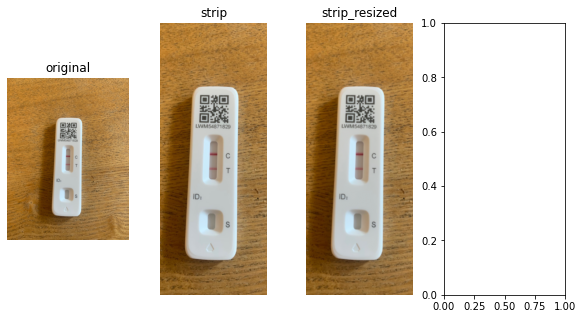

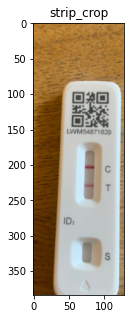

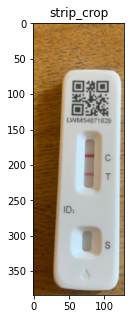

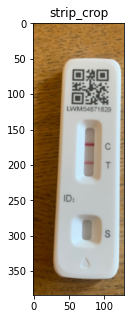

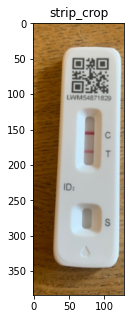

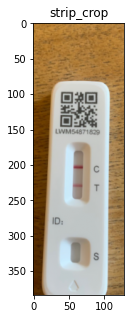

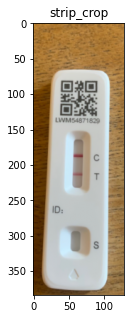

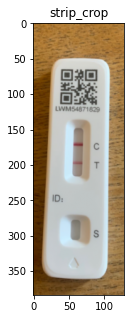

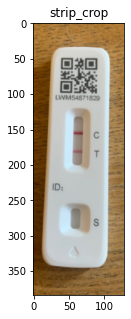

In [7]:
slider.stripping(64, lft_img.shape[1] // 4, 32)

box = slider.sliding(16)

(1366, 1024, 3)


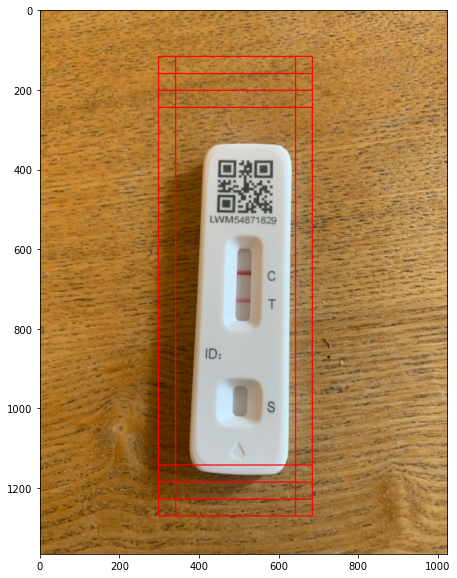

In [8]:
out_img = lft_img.copy()

print(lft_img.shape)

for b in box:
    row, col = draw.rectangle_perimeter(start=(b[0],b[1]), end=(b[2], b[3]))
    
    out_img[row+1, col+1, :] = [255, 0, 0] ## Red Color 
    out_img[row, col, :] = [255, 0, 0] ## Red Color 
    out_img[row-1, col-1, :] = [255, 0, 0] ## Red Color 

    
fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.imshow(out_img);
    